We will initialize our state model, our measurement model as well as our intial belief to calculate the evolution of state beliefs.

In [432]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stateModel = np.array([(0, 0, 0.10), \
                      (0.05, 0.10, 0.70), \
                      (0.15, 0.80, 0.15), \
                      (0.70, 0.10, 0.05), \
                      (0.10, 0, 0)])

stateLabels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]

measurementLabels = ["HALLWAY", "WALL", "OPEN DOOR", "CLOSED DOOR", "NOTHING"]

measurementProbabilities = np.array([[0.65, 0.10, 0.20, 0.05], \
                                    [0.05, 0.45, 0.10, 0.20], \
                                    [0.20, 0.10, 0.50, 0.15], \
                                    [0.05, 0.30, 0.15, 0.55], \
                                    [0.05, 0.05, 0.05, 0.05]])

measurementModel = pd.DataFrame(measurementProbabilities, \
                                index=measurementLabels, \
                                columns=measurementLabels[:-1])
stateMap = {"A": "WALL", \
            "B": "HALLWAY", \
            "C": "WALL", \
            "D": "CLOSED DOOR", \
            "E": "WALL", \
            "F": "OPEN DOOR", \
            "G": "WALL", \
            "H": "CLOSED DOOR", \
            "I": "WALL", \
            "J": "HALLWAY"}

In [433]:
print(measurementModel)

             HALLWAY  WALL  OPEN DOOR  CLOSED DOOR
HALLWAY         0.65  0.10       0.20         0.05
WALL            0.05  0.45       0.10         0.20
OPEN DOOR       0.20  0.10       0.50         0.15
CLOSED DOOR     0.05  0.30       0.15         0.55
NOTHING         0.05  0.05       0.05         0.05


In [450]:
initialBelief = pd.Series((1, 0, 0, 0, 0, 0, 0, 0, 0, 0), index=stateLabels)

In [435]:
def addPadding(stateProbabilities, amountOfPadding=5, paddingNum=0):
    padding = pd.Series([paddingNum]*amountOfPadding)
    paddedStateProbabilities = padding.append(stateProbabilities).append(padding)
    return paddedStateProbabilities

In [436]:
def removePadding(paddedStateProbabilities, amountOfPadding=5):
    stateProbabilities = paddedStateProbabilities[amountOfPadding:-amountOfPadding]
    return stateProbabilities

In [514]:
def mapStateToMeasurements(stateMap, measurementModel, measurement):
    states = sorted(stateMap.keys())
    measurementStateProbabilities = pd.Series()
    for state in states:
        measurementStateProbabilities[state] = measurementModel[stateMap[state]][measurement]
    return measurementStateProbabilities
        

In [539]:
def predictState(currentProbabilities, stateModel, controlInput):
    controlIndex = controlInput + 1
    predict = lambda window: np.multiply(window, stateModel[-window.size:,int(controlIndex)]).sum()
    statePredictions = currentProbabilities.rolling(stateModel.shape[0], center=True, min_periods=1).apply(predict)
    
    normalizationConstant = 1/statePredictions.sum()
    statePredictions *= normalizationConstant
    
    return statePredictions

In [516]:
def updateState(priorStateProbabilities, measurementStateProbabilities):
    stateUpdate = np.multiply(priorStateProbabilities, measurementStateProbabilities)
    
    normalizationConstant = 1/stateUpdate.sum()
    stateUpdate *= normalizationConstant
    return stateUpdate

In [518]:
def stepForward(stateMap, currentProbabilities, stateModel, \
                controlSignal, measurement, measurementModel, \
                defaultLocation, padding=True):
    
    currentProbabilities = addPadding(currentProbabilities) if padding else currentProbabilities
    priorStateProbabilities = predictState(currentProbabilities, \
                                           stateModel, controlSignal)
    
    measurementStateProbabilities = mapStateToMeasurements(stateMap, \
                                                           measurementModel, measurement)
    if padding:
        measurementStateProbabilities = addPadding(measurementStateProbabilities, \
                                                     paddingNum=measurementModel[measurement][defaultLocation]) 
    
    posteriorStateProbabilities = updateState(priorStateProbabilities, \
                                              measurementStateProbabilities)
    
    if padding:
        priorStateProbabilities = removePadding(priorStateProbabilities)
        posteriorStateProbabilities = removePadding(posteriorStateProbabilities)
        currentProbabilities = removePadding(currentProbabilities)
    states = currentProbabilities.index
    
    stepLabels = ["Current", "Control", "Prediction", "Measurement", "Update"]
    stepSummary = pd.concat([currentProbabilities, \
                             pd.Series(controlSignal, index=states), \
                             priorStateProbabilities, \
                             pd.Series(measurement, index=states), \
                             posteriorStateProbabilities], \
                             axis=1)
    
    stepSummary.columns = stepLabels
    
    return stepSummary
        

In [492]:
controlSignalHistory = pd.Series((1, 1, 1, 0, 1, 1, 1, 1, 1, np.nan))
measurementHistory = pd.Series((np.nan, "HALLWAY", "WALL", "WALL", \
                                "CLOSED DOOR", "WALL", "WALL", \
                                "OPEN DOOR", "WALL", "CLOSED DOOR"))
robotHistory = pd.concat((controlSignalHistory, measurementHistory), axis=1)
robotHistory.columns = ["Control", "Measurement"]


In [493]:
print(robotHistory)

   Control  Measurement
0      1.0          NaN
1      1.0      HALLWAY
2      1.0         WALL
3      0.0         WALL
4      1.0  CLOSED DOOR
5      1.0         WALL
6      1.0         WALL
7      1.0    OPEN DOOR
8      1.0         WALL
9      NaN  CLOSED DOOR


In [494]:
def generateMultiIndex(step, states):
    associations = []
    for state in states:
        associations.append((step, state))
    index = pd.MultiIndex.from_tuples(associations, names=['k', 'state'])
    print(index)
    return index
    

In [544]:
def bayesianEstimator(robotHistory, initialBelief, stateMap, stateModel, measurementModel, defaultLocation, padding=True):
    stateEvolution = list()
    currentBelief = initialBelief
    states = initialBelief.index
    for step in robotHistory.index[:-1]:
        #index = generateMultiIndex(step, states)
        controlSignal = robotHistory.iloc[step]["Control"]
        measurement = robotHistory.iloc[step + 1]["Measurement"]
        stepPredictions = stepForward(stateMap, currentBelief, stateModel, controlSignal, measurement, measurementModel, defaultLocation, padding)
        stepPredictions.index = states
        stepPredictions.index.name = "State"
        currentBelief = stepPredictions["Update"]
        stateEvolution.append(stepPredictions)
    return stateEvolution

We will now try predicting the state of the robot assuming an infinite state space on either side. In reality, there is a padding of 5 states before "A" and after "J" since the probabilities vanish quickly and are pretty much zero at the ends. This is a more realistic estimate since, in the other case where we assumed the robot could not go backwards, we would have to update the state model to reflect that.

In [545]:
stateEvolution = bayesianEstimator(robotHistory, initialBelief, stateMap, stateModel, measurementModel, "WALL")

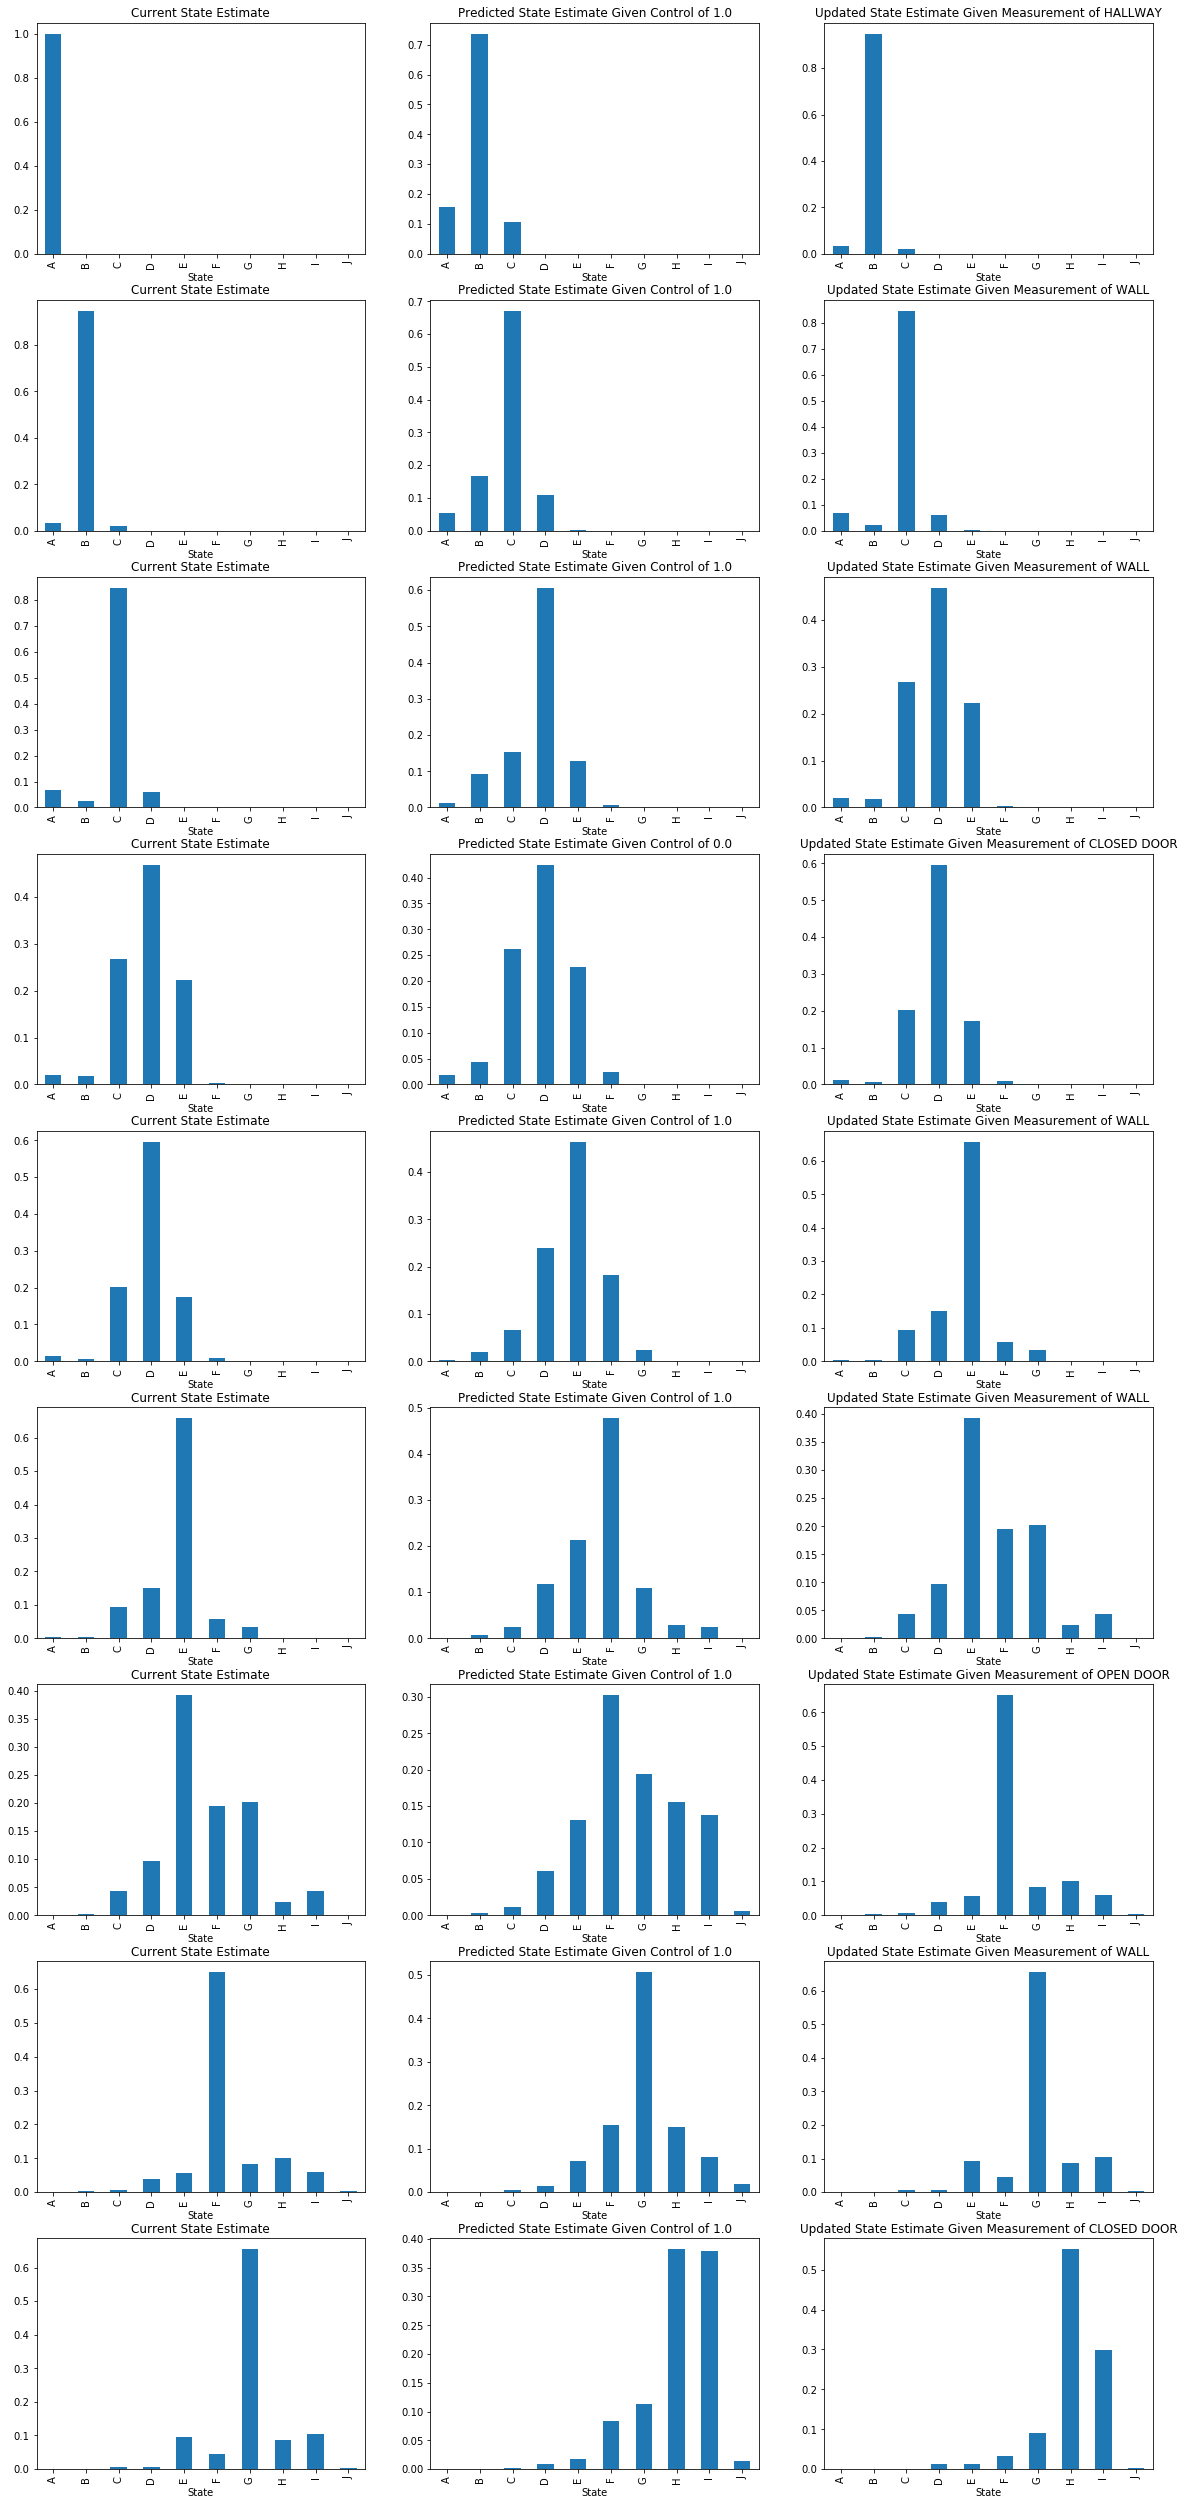

In [542]:
%matplotlib inline
fig, axes = plt.subplots(nrows=9, ncols=3)
figsize = (20, 45)
for step, stateSummary in enumerate(stateEvolution):
    stateSummary["Current"].plot(ax=axes[step,0],kind='bar', figsize=figsize, title="Current State Estimate")
    stateSummary["Prediction"].plot(ax=axes[step,1], kind='bar', figsize=figsize, title="Predicted State Estimate Given Control of {}".format(stateSummary["Control"][0]))
    stateSummary["Update"].plot(ax=axes[step,2], kind='bar', figsize=figsize, title="Updated State Estimate Given Measurement of {}".format(stateSummary["Measurement"][0]))
    

In [546]:
stateEvolution[8]["Update"]["H"]

0.68630134790391983

Just to test our model on the data in the notes.

In [547]:
testBelief = pd.Series([0.030, 0.020, 0.060, 0.140, 0.540, 0.090, 0.060, 0.020, 0.030, 0.010])


In [548]:
stepForward(stateMap, testBelief, stateModel, \
                1, "HALLWAY", measurementModel, \
                "WALL", padding=True)

,Current,Control,Prediction,Measurement,Update
0,0.03,1,0.0055,HALLWAY,0.003412
1,0.02,1,0.0270,HALLWAY,0.108888
2,0.06,1,0.0330,HALLWAY,0.020475
3,0.14,1,0.0920,HALLWAY,0.028540
4,0.54,1,0.1895,HALLWAY,0.117574
5,0.09,1,0.4085,HALLWAY,0.506902
6,0.06,1,0.1270,HALLWAY,0.078796
7,0.02,1,0.0555,HALLWAY,0.017217
8,0.03,1,0.0250,HALLWAY,0.015511
9,0.01,1,0.0245,HALLWAY,0.098806
